# All good with Seurasaaris trees?

Let's think back to September 2021, nice and warm it was. But was it too warm for the trees on [Seurasaari](https://www.hel.fi/helsinki/en/culture/recreation/in-helsinki/seurasaari)? 

Let's see if we can answer this by using some freely available data and open source tools.


We will use EO data...
We have a specific timeframe and a specific place, so Earth Observation data seems a good way to go. 


We will use multispectral data...

We will use Sentinel-2 ...

And since we are interested in spectral information rather than structural, let's look at multispectral data, like Landsat 8 or Sentinel-2. Seurasaari is rather small in size, so let's got with Sentinel-2 which provides up to 10 m spatial resolution.

There is many tools around to get this data. E.g. https://scihub.copernicus.eu/dhus/ as graphical web interface. With [FORCE](https://force-eo.readthedocs.io/en/latest/) and [sentinelsat](https://sentinelsat.readthedocs.io/en/stable/) are examples of tools that are used from the command line.

Lucky for us, we do not have to deal with the data finding right now, as we find a file on Allas that includes 4 band (rgbnir) Sentinel-2 data of 26.09.2021 that we had prepared for some other project.
-> `S2B_RGBNIR_20210926_Helsinki.tif`
Let's get it and have a look...

For raster data analysis we will be using [Rasterio](https://rasterio.readthedocs.io/en/latest/intro.html] package which depends on [GDAL](https://gdal.org/). 

(Direct [GDAL Python bindings](https://gdal.org/api/python.html) do also exist, but we will not use them in this course. [Rioxarray](https://corteva.github.io/rioxarray/html/readme.html) is a rasterio extension for working with xarray (which we will not be using today).)

In [ ]:
# first we need to import rasterio library (https://rasterio.readthedocs.io/en/latest/)
import rasterio
print(rasterio.__version__)

import seurasaari_toolbox as stb

Then we can read our file directly from Allas utilizing 'vsicurl' and the link to our file on Allas public bucket: https://a3s.fi/gis-courses/pythongis_2022/S2B_RGBNIR_20210926_Helsinki.tif

#s2tif = rasterio.open('/vsicurl/https://a3s.fi/gis-courses/pythongis_2022/S2B_RGBNIR_20210926_Helsinki.tif')

However, we do not want to overload the system, so let's rather make a local copy using proovided script

In [180]:




url_list = ['https://a3s.fi/gis-courses/pythongis_2022/S2B_RGBNIR_20210926_Helsinki.tif']
stb.download_data(url_list)

# downloads data into ./data directory from where we can read it

s2file = './data/S2B_RGBNIR_20210926_Helsinki.tif'

s2tif = rasterio.open(s2file)

s2tif

<open DatasetReader name='./data/S2B_RGBNIR_20210926_Helsinki.tif' mode='r'>

In [181]:
# Now we can check that this worked by having a look at the metadata
s2tif.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 2466,
 'height': 1832,
 'count': 4,
 'crs': CRS.from_epsg(32635),
 'transform': Affine(10.0, 0.0, 379820.0,
        0.0, -10.0, 6685870.0)}

This did not tell too much about the trees, better to actually have a look what the data looks like
The near infrared band (4) should have something to do with vegetation...

![](./img/vegetation_reflectance.png)

Credit: Physicsopenlab, http://physicsopenlab.org/wp-content/uploads/2017/01/veg.gif

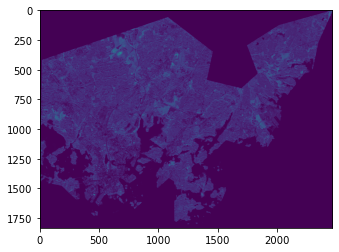

In [343]:
from rasterio.plot import show

#read the nir band into a variable
nir = s2tif.read(4)

type(nir)

#and plot the band
show(nir);

In [344]:
# ok, there is Helsinki, but maybe only the nir band is not enough to look at...
# let's plot a 'common false color image' instead
# we need arrays of nir , green, red to be interpreted as rgb

# Read the grid values into numpy arrays
# nir we already have in memory
red = s2tif.read(3)
green = s2tif.read(2)

In [345]:
#show only takes single band inputs, so we need to find a different way
#matplotlib pyplots imshow can plot normal images, so why not also EO products
import matplotlib.pyplot as plt
%matplotlib inline

In [346]:
# normal images are stacks of RGB, lets recreate that for our false color composite
import numpy as np

# the composite of our choice should show nir as red, red as blue and green as green
# we will use dstack fuction of np to build composite of the bands
stack = np.dstack((nir, red, green))

stack.shape

(1832, 2466, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


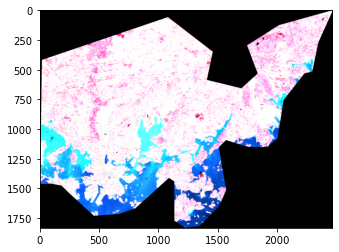

In [347]:
# so let's plot it
plt.imshow(stack)

In [353]:
# this does not look too good for an image, let's fix the range (imshow just clips it, we want to normalize)


normnir = stb.normalize(nir)
normred = stb.normalize(red)
normgreen = stb.normalize(green)

print('before')
print(red.min(), '-', red.max(), 'mean:', red.mean())
print('after')
print(normred.min(), '-', normred.max(), 'mean:', normred.mean())

before
0 - 16208 mean: 288.11542457775084
after
0.0 - 1.0 mean: 0.01777612441866676


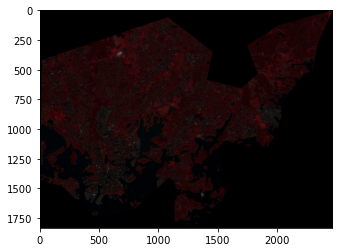

In [354]:
#stack and plot normalized version

normstack = np.dstack((normnir, normred, normgreen))
plt.imshow(normstack);

In [355]:
# too dark
# let's try and fix this with a histogram stretch


stretchnir = stb.stretch(nir)
stretchred = stb.stretch(red)
stretchgreen = stb.stretch(green)

print('before')
print(red.min(), '-', red.max(), 'mean:', red.mean())
print('after')
print(stretchred.min(), '-', stretchred.max(), 'mean:', stretchred.mean())

before
0 - 16208 mean: 288.11542457775084
after
0 - 255 mean: 47.805121486274466


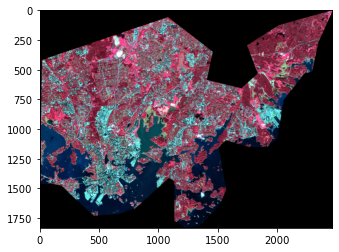

In [356]:
#stack and plot normalized version

stretchstack = np.dstack((stretchnir, stretchred, stretchgreen))
plt.imshow(stretchstack);

Ah yes, vegetation in red, all good!

However, cannot really see what is going on on Seurasaari.

Since we are not interested in the rest of Helsinki, let's clip out Seurasaari

In [196]:
# first we need to find Seurasaari, and there is only one in Helsinki

import osmnx as ox

# Keywords for Seurasaari in such format that they can be found from OSM: https://nominatim.openstreetmap.org/ui/search.html
seurasaari_q = "Seurasaari, Helsinki, Finland"

# Retrieve the geometries of those areas using osmnx
seurasaari = ox.geocode_to_gdf(seurasaari_q)

seurasaari.crs



/home/samwitt/miniconda3/envs/autogis-environment/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [197]:
# put in same crs
seurasaari = seurasaari.to_crs(crs=s2tif.crs)

seurasaari.crs


<Derived Projected CRS: EPSG:32635>
Name: WGS 84 / UTM zone 35N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 35N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [229]:
# we need to get the format of the seurasaari polygon into something usable for rasterio (https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask)

coords = stb.getFeatures(seurasaari)

coords


[{'type': 'Polygon',
  'coordinates': [[[382344.9971561417, 6673616.888177212],
    [382354.17072542664, 6673590.915943632],
    [382370.7947931855, 6673576.2057031905],
    [382373.0829994244, 6673572.78877031],
    [382373.6379052509, 6673567.254306869],
    [382371.5774497742, 6673561.692424062],
    [382368.7605197756, 6673555.218691007],
    [382363.1698960569, 6673550.1825911775],
    [382360.9895701044, 6673544.000460709],
    [382357.4774862489, 6673538.696977576],
    [382355.1685323106, 6673531.794576373],
    [382351.6784313597, 6673527.003048768],
    [382351.524597344, 6673522.215762683],
    [382351.3167443606, 6673512.637983154],
    [382352.2202723919, 6673504.997106341],
    [382346.5148927006, 6673502.784329697],
    [382343.2367288743, 6673498.197747812],
    [382345.187057986, 6673493.420856412],
    [382352.77284785797, 6673492.998777486],
    [382356.63237601274, 6673492.874760614],
    [382358.50383560726, 6673489.270606826],
    [382372.888402302, 6673482.244198

In [230]:
# now we crop the Sentinel2 product with the Seurasaari polygon

from rasterio.mask import mask

seurasaariS2ar, seurasaariS2_transform = mask(dataset=s2tif, shapes=coords, crop=True)

# check the shape -> much smaller!
seurasaariS2ar.shape


(4, 118, 68)

In [358]:
# Copy the metadata
seurasaariS2_meta = s2tif.meta.copy()

seurasaariS2_meta.update({"height": seurasaariS2ar.shape[1],
                 "width": seurasaariS2ar.shape[2]})

#metadata as keyword arguments (key-value pairs)

seurasaariS2tif = './data/S2B_RBGNIR_20210926_Seurasaari.tif'
with rasterio.open(seurasaariS2tif, "w", **seurasaariS2_meta) as dest:
        dest.write(seurasaariS2ar)

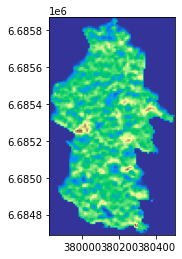

In [232]:
# Open the clipped raster file
seurasaariS2 = rasterio.open(seurasaariS2tif)

# Visualize
show((seurasaariS2, 4), cmap='terrain');

In [360]:
#Great! Let's look again at the false color image



falsecolorstack = stb.make_false_color_image(seurasaariS2)

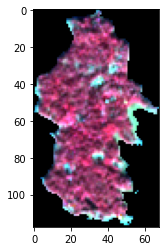

In [361]:
plt.imshow(falsecolorstack);

This looks quite red, so it seems the trees were doing well in general.


## NDVI

Why look at NDVI...


 INdicatopr for  vegetation health is by using the [Normalized Difference Vegetation Index, NDVI](https://gisgeography.com/ndvi-normalized-difference-vegetation-index/) 

![](./img/ndvi.jpg)

Credit: Robert Simmon, NASA, https://www.nasa.gov/topics/earth/features/obscure_data.html

Formula:

$$NDVI = \frac{nir-red}{nir+red}$$

So we will do some band math / map algebra. Since we can read our data into numpy arrays, let's utilize that:



In [255]:

# first we need to read the red and nir bands into arrays
# Read red channel (our channel number 3)
red = seurasaariS2.read(3)
# Read NIR channel (our channel number 4)
nir = seurasaariS2.read(4)

# check arrays datatype; range of NDVI is [0,1] -> float
red.dtype

dtype('uint16')

In [256]:

# Convert to floats
# https://numpy.org/doc/1.20/user/basics.types.html

red = red.astype('f4')
nir = nir.astype('f4')

# since the divisor can become 0, we choose to ignore that error from numpy
np.seterr(divide='ignore', invalid='ignore');


In [257]:
# Calculate NDVI using numpy arrays



ndvi = (nir - red) / (nir + red)


np.nanmax(ndvi)

0.9434851

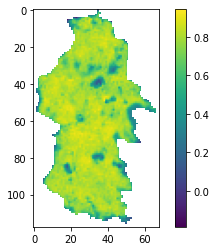

In [260]:

# Plot the NDVI
plt.imshow(ndvi, cmap='viridis')
# Add colorbar to show the index
plt.colorbar();

In [261]:
# lets store this for later

ndvi_meta = s2tif.meta.copy()

ndvi_meta.update({"count" : 1,
                "dtype" : np.dtype('f4')})

with rasterio.open("./data/seurasaari_ndvi.tif", "w", **ndvi_meta) as dest:
    dest.write_band(1, ndvi.astype(rasterio.float32))

Looks like vegetation is doing well on Seurasaari. But what are those darker areas?

It is possible that not everything is trees on Seurasaari.

Let's check what else there is...

There is many possibilities to do that, one  way is to look at the land cover classification [Corine](https://land.copernicus.eu/pan-european/corine-land-cover) , wich SYKE kindly provides for Finland: https://ckan.ymparisto.fi/dataset/%7B0B4B2FAC-ADF1-43A1-A829-70F02BF0C0E5%7D with the categories provided as excel sheet: https://geoportal.ymparisto.fi/meta/julkinen/dokumentit/CorineMaanpeite2018Luokat.xls


First, lets visualize Corine data of Seurasaari:


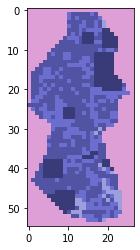

In [283]:
corinefile = './data/Clc2018_Seurasaari.tif'

with rasterio.open(corinefile) as corine:
    show(corine.read(1), cmap = 'tab20b')

So we have multiple different classes on Seurasaari.
We can also use `zonal_stats` function from [rasterstats](https://pythonhosted.org/rasterstats/) to check what kind of land cover classes are on Seurasaari.

In [363]:
from rasterstats import zonal_stats

#zstats = zonal_stats(seurasaari, corinefile)
zstats = zonal_stats(seurasaari, corinefile, categorical=True)
zstats

[{2: 12,
  3: 89,
  4: 42,
  14: 10,
  23: 20,
  25: 303,
  27: 140,
  28: 137,
  30: 38,
  33: 1,
  34: 31,
  36: 51,
  39: 3,
  41: 3,
  45: 7,
  46: 4,
  48: 15,
  49: 2}]

Now it would be great to know what these classes are to find out what is forest. Luckily class descriptions are provided as excel file, of which we can pack the interesting (english and detailed) description into a dictionary:

In [341]:


catdict = stb.get_corine_dict()

TypeError: get_limited_df() takes 0 positional arguments but 1 was given

In [298]:
catdict

{1.0: 'Continuous urban fabric',
 2.0: 'Discontinuous urban fabric',
 3.0: 'Commercial units',
 4.0: 'Industrial units',
 5.0: 'Road and rail networks and associated land',
 6.0: 'Port areas',
 7.0: 'Airports',
 8.0: 'Mineral extraction sites',
 9.0: 'Open cast mines',
 10.0: 'Dump sites',
 11.0: 'Construction sites',
 12.0: 'Green urban areas',
 13.0: 'Summer cottages',
 14.0: 'Sport and leisure areas',
 15.0: 'Golf courses',
 16.0: 'Racecourses',
 17.0: 'Non-irrigated arable land',
 18.0: 'Fruit trees and berry plantations',
 19.0: 'Pastures',
 20.0: 'Natural pastures',
 nan: nan,
 21.0: 'Arable land outside farming subsidies',
 22.0: 'Agro-forestry areas',
 23.0: 'Broad-leaved forest on mineral soil',
 24.0: 'Broad-leaved forest on peatland',
 25.0: 'Coniferous forest on mineral soil',
 26.0: 'Coniferous forest on peatland',
 27.0: 'Coniferous forest on rocky soil',
 28.0: 'Mixed forest on mineral soil',
 29.0: 'Mixed forest on peatland',
 30.0: 'Mixed forest on rocky soil',
 31.0: 

We can add this directly to zonal stats to get the output human reader friendly with classnames instead of numbers (https://pythonhosted.org/rasterstats/manual.html#working-with-categorical-rasters):

In [293]:
zstats = zonal_stats(seurasaari,corinefile, categorical=True, category_map=catdict, stats=['count'])


In [294]:
zstats

[{'Discontinuous urban fabric': 12,
  'Commercial units': 89,
  'Industrial units': 42,
  'Sport and leisure areas': 10,
  'Broad-leaved forest on mineral soil': 20,
  'Coniferous forest on mineral soil': 303,
  'Coniferous forest on rocky soil': 140,
  'Mixed forest on mineral soil': 137,
  'Mixed forest on rocky soil': 38,
  'Transitional woodland/shrub  cc <10%  ': 1,
  'Transitional woodland/shrub, cc 10-30%,on mineral soil': 31,
  'Transitional woodland/shrub, cc 10-30%,  on rocky soil': 51,
  'Bare rock': 3,
  'Inland marshes, terrestrial': 3,
  'Salt marshes, terrestrial': 7,
  'Salt marshes, aquatic': 4,
  'Water bodies': 15,
  'Sea and ocean': 2,
  'count': 908}]

In [295]:

stb.get_zonal_stats_percentage(zstats)


{'Discontinuous urban fabric': 1,
 'Commercial units': 10,
 'Industrial units': 5,
 'Sport and leisure areas': 1,
 'Broad-leaved forest on mineral soil': 2,
 'Coniferous forest on mineral soil': 33,
 'Coniferous forest on rocky soil': 15,
 'Mixed forest on mineral soil': 15,
 'Mixed forest on rocky soil': 4,
 'Transitional woodland/shrub  cc <10%  ': 0,
 'Transitional woodland/shrub, cc 10-30%,on mineral soil': 3,
 'Transitional woodland/shrub, cc 10-30%,  on rocky soil': 6,
 'Bare rock': 0,
 'Inland marshes, terrestrial': 0,
 'Salt marshes, terrestrial': 1,
 'Salt marshes, aquatic': 0,
 'Water bodies': 2,
 'Sea and ocean': 0}

Now we know that there are commercial and industrial units on Seurasaari. Note that the Corine file was clipped approximately at the coast, which explains that there is 0.x% of sea and ocean and bare rock, even though if you have ever been to Seurasaari we know it is there.

But we are only interested in trees (forest in Corine case), so lets filter out only forest classes: 'Broad-leaved forest on mineral soil', 'Coniferous forest on mineral soil', 'Coniferous forest on rocky soil', 'Mixed forest on mineral soil', 'Mixed forest on rocky soil'.

In [315]:
# Lets consider only vegetation
vegetation = ['Broad-leaved forest on mineral soil',
 'Coniferous forest on mineral soil',
 'Coniferous forest on rocky soil',
 'Mixed forest on mineral soil',
 'Mixed forest on rocky soil']


-> into toolbox



catdf_lim = stb.get_limited_df()

vegdf = catdf_lim[catdf_lim['Level4Eng'].isin(vegetation)]

veglist = vegdf.index.to_list()

veglist

[23.0, 25.0, 27.0, 28.0, 30.0]

So we have now have a dataframe that only containes forest related classes that are present on Seurasaari.

Next, let's use numpy to create a mask from only forest classes:

In [314]:
# read the first and only band of the Corine dataset
with rasterio.open('./data/Clc2018_Seurasaari.tif') as corine:
    corinearray = corine.read(1)
    
corinearray

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

Now we mask the corinearray everywhere where there is any of the forest classes:

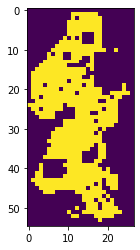

bool


In [368]:


#mask = np.where(corinearray in veglist,1)

mask = (corinearray == int(veglist[0])) |  (corinearray == int(veglist[1])) | (corinearray == int(veglist[2])) | (corinearray == int(veglist[3])) | (corinearray == int(veglist[4]))
show(mask,1)

# -> yellow: forest; purple: everything else
# currently mask is boolean, but we rather want it binary:

mask = mask.astype('uint8')


Now we store the resulting mask as a shapefile:

In [324]:
import fiona
from rasterio import features


#iterate over shapes.
results = (
    {'properties': {'raster_val': v}, 'geometry': s}        
    for i, (s, v) in enumerate(features.shapes(mask, transform = corine.transform)))

with fiona.open(
        './data/forestmask_corine_seurasaari.shp', 'w',
        driver='Shapefile',
        crs=corine.crs,
        schema={'properties': [('raster_val', 'int')],
        'geometry': 'Polygon'}) as dst:
    dst.writerecords(results)

We mask the NDVI product with the just created mask to just look at forests NDVI:

In [329]:
import fiona
import rasterio
import rasterio.mask


# we only want to regard polygons that have the value 1 (forest)
with fiona.open("./data/forestmask_corine_seurasaari.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile if feature['properties']['raster_val'] == 1]
    print(shapefile[0])

#open the Seurasaari NDVI file and use rasterio mask to mask out areas that are not forest
with rasterio.open('./data/seurasaari_ndvi.tif') as ndvi:
    out_image, out_transform = rasterio.mask.mask(ndvi, shapes, crop=True)
    out_meta = ndvi.meta.copy()

with rasterio.open("seurasaari_S2_ndvi_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

{'type': 'Feature', 'id': '0', 'properties': OrderedDict([('raster_val', 0)]), 'geometry': {'type': 'Polygon', 'coordinates': [[(382619.9999999997, 6673960.0), (382639.9999999997, 6673960.0), (382639.9999999997, 6673940.0), (382619.9999999997, 6673940.0), (382619.9999999997, 6673960.0)]]}}


Now we can get one value to indicate "how healthy the trees on Seurasaari were in end of September 2021":

In [370]:
ndvi_veg = rasterio.open("./data/seurasaari_masked.tif").read(1)
print(np.mean(ndvi_veg))
print(np.nanmean(ndvi_veg))

nan
0.35075343


seems a bit little for what we have seen before?
Let's check the distribution of NDVI values from a histogram with rasterios `show_hist` function (https://rasterio.readthedocs.io/en/latest/api/rasterio.plot.html#rasterio.plot.show_hist):

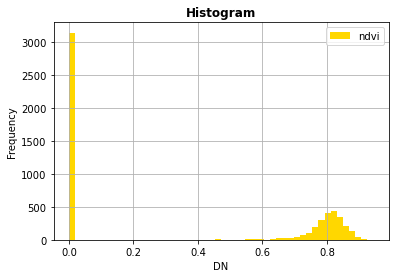

In [373]:
from rasterio.plot import show_hist


show_hist(ndvi_veg, bins=50, lw=0.0, stacked=False, alpha=1,
      histtype='stepfilled', label = 'ndvi')

# mention pyplot integration



Assumption: Unlikely that there is any plain 0 values. 
-> we can remove them from the array

In real life, please do not just do that, but make sure `no data` values are `nan` rather than 0! 

In [340]:

ndvi_veg[ndvi_veg == 0] = np.nan

np.nanmean(ndvi_veg)

nan


0.7976835

Seems like the trees on Seurasaari are healthy and green :)

TODO:


* make chapters

* in between checks
* outsourced files naming -> all in one file? comments!
* make lesson material and empty notebook from it
* activation questions
* time it
* create datafiles and clean script
* check that all files are closed
* provide objectives and summary for lesson
* script to do the masking correctly, no 0 values.

* extra Exercises: 
    * "which one is higher, P or Kallio"?
    * Mosaic DEMs

